In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ Custom Lag Compensation Layer
class LagCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T1=0.1, **kwargs):
        super(LagCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T1 = T1

    def call(self, inputs):
        return self.K * (inputs + self.T1 * tf.nn.relu(inputs))

# ✅ Custom Lead Compensation Layer
class LeadCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T2=0.05, **kwargs):
        super(LeadCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T2 = T2

    def call(self, inputs):
        return self.K * (inputs - self.T2 * tf.nn.relu(-inputs))

# ✅ Build EfficientNet-B3 with Lag-Lead Compensation
def build_efficientnet_b3_with_compensation(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Load EfficientNet-B3 as feature extractor
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output

    # Apply Lag Compensation as a Layer
    x_lag = LagCompensationLayer()(x)

    # Apply Lead Compensation as a Layer
    x_lead = LeadCompensationLayer()(x)

    # Merge compensated outputs
    x = layers.Concatenate()([x, x_lag, x_lead])  # Increase feature depth

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Output Layer (Binary Classification)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# ✅ Define Input Shape (300x300 RGB)
input_shape = (300, 300, 3)

# ✅ Build Model
model = build_efficientnet_b3_with_compensation(input_shape)

# ✅ Display Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 300, 300, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,788,144 (41.15 MB)

 Trainable params: 10,700,841 (40.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install sciPY
import scipy
!pip install matplotlib
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install Pillow
!pip install tensorflow
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
#from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential  # Assuming TensorFlow 2.0+
import keras
!pip install keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install keras-preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
import PIL.Image
from tensorflow.keras.preprocessing.image import load_img

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
! pip install --upgrade pip
!pip install --upgrade Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:

import cv2
import numpy as np
import os
# Input and Output directories
input_dir = "/content/unzip/1111/Bengin cases"
output_dir = "/content/unzip/1111/Bengin cases"
angles = [15, 30, 45, 60]  # Define rotation angles

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue  # Skip if the image is not loaded properly

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Apply rotations and save images
    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))

        new_filename = f"rotated_{angle}_{filename.split('.')[0]}.png"
        cv2.imwrite(os.path.join(output_dir, new_filename), rotated)

In [ ]:
import os
from PIL import Image

def resize_images(input_folder, output_folder, target_size=(300, 300)):
    """
    Resizes all images in the input_folder to the target_size and saves them in the output_folder.

    Args:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder to save resized images.
        target_size (tuple): Desired size for resized images (width, height).
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        try:
            # Open the image
            with Image.open(input_path) as img:
                # Resize the image
                img_resized = img.resize(target_size, Image.ANTIALIAS)

                # Save the resized image in the output folder
                output_path = os.path.join(output_folder, filename)
                img_resized.save(output_path)
                print(f"Resized and saved: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
input_folder = "/content/unzip"
output_folder = "/content/outputresize"
resize_images(input_folder, output_folder)

Error processing 1111: [Errno 21] Is a directory: '/content/unzip/1111'


In [ ]:
#count number of images and classes Benign=0 maligant=1
ROOT_DIR="/content/unzip/1111"
number_of_images={}
for dir in os.listdir(ROOT_DIR):
       number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
       number_of_images.items()

In [ ]:
number_of_images.items()

dict_items([('Bengin cases', 600), ('Malignant cases', 561)])

In [ ]:
# Count the number of images in each class
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# Split the dataset: 70% training, 15% testing, and 15% validation
if not os.path.exists("./train111x"):
    os.mkdir("./train111x")
    os.mkdir("./test111x")
    os.mkdir("./validation111x")

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./train111x/" + dir)
        os.makedirs("./test111x/" + dir)
        os.makedirs("./validation111x/" + dir)
        # Calculate the number of images for each split
        train_size = math.floor(0.7 * number_of_images[dir])
        test_size = math.floor(0.15 * number_of_images[dir])
        validation_size = number_of_images[dir] - train_size - test_size

        # Get a random sample of images for each split
        all_images = os.listdir(os.path.join(ROOT_DIR, dir))
        train_images = np.random.choice(all_images, size=train_size, replace=False)
        remaining_images = list(set(all_images) - set(train_images))
        test_images = np.random.choice(remaining_images, size=test_size, replace=False)
        validation_images = list(set(remaining_images) - set(test_images))

        # Move images to the appropriate folders
        for img in train_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./train111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in test_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./test111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in validation_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./validation111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)
else:
    print("The folders already exist.")

In [ ]:
# Count the number of images in the validation folder
number_of_images_val = {}
for dir in os.listdir("./validation111x"):
    number_of_images_val[dir] = len(os.listdir(os.path.join("./validation111x", dir)))

number_of_images_val

{'Bengin cases': 90, 'Malignant cases': 85}

In [ ]:
# Count the number of images in the training folder
number_of_images_train = {}
for dir in os.listdir("./train111x"):
    number_of_images_train[dir] = len(os.listdir(os.path.join("./train111x", dir)))

number_of_images_train

{'Bengin cases': 420, 'Malignant cases': 392}

In [ ]:
# Count the number of images in the test folder
number_of_images_test = {}
for dir in os.listdir("./test111x"):
    number_of_images_test[dir] = len(os.listdir(os.path.join("./test111x", dir)))

number_of_images_test

{'Bengin cases': 90, 'Malignant cases': 84}

In [ ]:
import tensorflow as tf  # Assuming you're using TensorFlow with Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data directories
train_path = "train111x"
validation_path = "validation111x"
# test_path = "test400"  # Separate directory for testing

# Set up data generators for training, validation, and testing

def preprocessing_images(path, target_size=(300, 300), batch_size=32, class_mode='binary'):
    """
    Preprocesses images using ImageDataGenerator and returns a data generator.

    Args:
        path: Path to the directory containing images.
        target_size: Target size (width, height) to resize the images.
        batch_size: Batch size for training the model.
        class_mode: Mode for classifying images ('binary' for 2 classes,
                     'categorical' for more than 2 classes).

    Returns:
        A Keras ImageDataGenerator object representing the preprocessed dataset.
    """
    image_data = ImageDataGenerator(
        rescale=1/255  # Normalize pixel values to [0, 1]
    )

    # Use flow_from_directory to create data generators
    image_generator = image_data.flow_from_directory(
        directory=path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    return image_generator

# Create training, validation, and test data generators
train_data = preprocessing_images(train_path)
val_data = preprocessing_images(validation_path)
# test_data = preprocessing_images(test_path)  # Create a separate generator for testing

# Build your image classification model (code not provided)

# Train your model using train_data and val_data for validation

# Evaluate your model's performance on the test set using test_data

Found 812 images belonging to 2 classes.
Found 175 images belonging to 2 classes.


In [ ]:
import tensorflow as tf  # Assuming you're using TensorFlow with Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data directories
train_path = "/content/train111x"
# test_path = "test400m"

# Set up data generators for training and validation

def preprocessingImages(path):
    """
    Preprocesses images using ImageDataGenerator and returns a data generator.

    Args:
        path: Path to the directory containing images.

    Returns:
        A Keras ImageDataGenerator object representing the preprocessed dataset.
    """
    image_data = ImageDataGenerator(
        rescale=1/255  # Normalize pixel values to [0, 1]
    )
    image = image_data.flow_from_directory(directory=path, target_size=(300, 300), batch_size=32, class_mode='binary')
    return image

train_data = preprocessingImages(train_path)
# test_data = preprocessingImages(test_path)
val_data = preprocessingImages(validation_path)  # Create validation data similarly to training data.

Found 812 images belonging to 2 classes.
Found 175 images belonging to 2 classes.


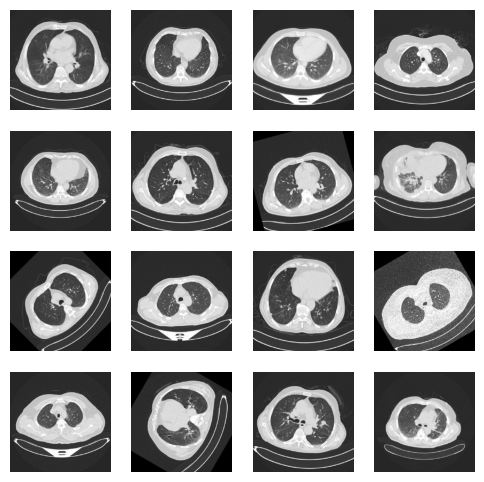

Total augmented images: 1664


In [ ]:
# Assuming you have already imported necessary libraries (e.g., ImageDataGenerator, matplotlib)
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = next(train_data)  # Get a batch of augmented images

# Display a few augmented images
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    if i < len(augmented_images[0]):  # Check if index is within bounds
        ax.imshow(augmented_images[0][i])
        ax.axis('off')
plt.show()

num_batches = len(train_data)  # Number of batches
batch_size = 64  # Your specified batch size
total_augmented_images = num_batches * batch_size
print(f"Total augmented images: {total_augmented_images}")

In [ ]:
#Define your data directories
train_path = "train111x"
#test_path = "test400"

# Set up data generators for training and validation
def preprocessingImages(path):
    # Apply data augmentation (rotation and flip)
    image_data = ImageDataGenerator(
        rescale=1/255,
        zoom_range=0.1,
        shear_range=0.2,
        rotation_range=30,  # Rotate images randomly up to 20 degrees
        horizontal_flip=True,  # Flip images horizontally
        vertical_flip=True  # Flip images vertically
    )
    image = image_data.flow_from_directory(directory=path, target_size=(300, 300), batch_size=40, class_mode='binary')
    return image

train_data = preprocessingImages(train_path)
val_data = preprocessingImages(validation_path)  # Create validation data similarly to training data

print("Data generators for training and validation (with data augmentation) created successfully!")

Found 812 images belonging to 2 classes.
Found 175 images belonging to 2 classes.
Data generators for training and validation (with data augmentation) created successfully!


In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2
import PIL.Image

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Swish activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# Squeeze-and-Excitation block
def se_block(inputs, se_ratio=0.25):
    input_channels = inputs.shape[-1]
    reduced_channels = max(1, int(input_channels * se_ratio))

    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Reshape((1, 1, input_channels))(x)
    x = layers.Conv2D(reduced_channels, kernel_size=1, activation='swish')(x)
    x = layers.Conv2D(input_channels, kernel_size=1, activation='sigmoid')(x)
    return layers.Multiply()([inputs, x])

# MBConv block
def mbconv_block(inputs, expansion_factor, output_channels, kernel_size, stride, se_ratio, drop_rate):
    input_channels = inputs.shape[-1]
    expanded_channels = input_channels * expansion_factor

    # Expansion phase
    if expansion_factor != 1:
        x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(swish)(x)
    else:
        x = inputs

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    # Squeeze-and-Excitation
    x = se_block(x, se_ratio)

    # Projection phase
    x = layers.Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    if stride == 1 and input_channels == output_channels:
        if drop_rate > 0:
            x = layers.Dropout(drop_rate)(x)
        x = layers.Add()([inputs, x])
    return x

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ Custom Lag Compensation Layer
class LagCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T1=0.1, **kwargs):
        super(LagCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T1 = T1

    def call(self, inputs):
        return self.K * (inputs + self.T1 * tf.nn.relu(inputs))

# ✅ Custom Lead Compensation Layer
class LeadCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T2=0.05, **kwargs):
        super(LeadCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T2 = T2

    def call(self, inputs):
        return self.K * (inputs - self.T2 * tf.nn.relu(-inputs))

# ✅ Build EfficientNet-B3 with Lag-Lead Compensation
def build_efficientnet_b3_with_compensation(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Load EfficientNet-B3 as feature extractor
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output

    # Apply Lag Compensation as a Layer
    x_lag = LagCompensationLayer()(x)

    # Apply Lead Compensation as a Layer
    x_lead = LeadCompensationLayer()(x)

    # Merge compensated outputs
    x = layers.Concatenate()([x, x_lag, x_lead])  # Increase feature depth

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Output Layer (Binary Classification)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# ✅ Define Input Shape (300x300 RGB)
input_shape = (300, 300, 3)

# ✅ Build Model
model = build_efficientnet_b3_with_compensation(input_shape)

# ✅ Display Model Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 300, 300, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,788,144 (41.15 MB)

 Trainable params: 10,700,841 (40.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
import numpy as np

# Example data
train_data = np.random.random((100, 10))  # 100 samples, 10 features
y_train = np.random.randint(0, 2, (100,))  # Binary labels (0 or 1)

In [ ]:
val_data = np.random.random((20, 10))  # 20 validation samples
y_val = np.random.randint(0, 2, (20,))  # Binary validation labels

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("saved_models/efficientnet_b3_with_compensations.keras")

# Summary of the loaded model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 298, 298, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2841728)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │       2,841,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,527,877 (32.53 MB)

 Trainable params: 2,842,625 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,685,252 (21.69 MB)

In [ ]:
import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/42.zip'

# Specify the directory where you want to extract the files
extract_to_dir = '/content/unzip'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Print a message indicating the extraction directory
print(f"Files extracted to {extract_to_dir}")

Files extracted to /content/unzip


In [ ]:
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install sciPY
import scipy
!pip install matplotlib
import numpy as np
import matplotlib
import shutil
import glob
import os
import math
!pip install Pillow
!pip install tensorflow
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
#from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential  # Assuming TensorFlow 2.0+
import keras
!pip install keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install keras-preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
import PIL.Image
from tensorflow.keras.preprocessing.image import load_img

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
# Input and Output directories
input_dir = "/content/unzip/1111/Bengin cases"
output_dir = "/content/unzip/1111/Bengin cases"
angles = [15, 30, 45, 60]  # Define rotation angles

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue  # Skip if the image is not loaded properly

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Apply rotations and save images
    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))

        new_filename = f"rotated_{angle}_{filename.split('.')[0]}.png"
        cv2.imwrite(os.path.join(output_dir, new_filename), rotated)

In [ ]:
import cv2
import numpy as np
import os
# Input and Output directories
input_dir = "/content/unzip/1111/Malignant cases"
output_dir = "/content/unzip/1111/Malignant cases"
angles = [15, 30, 45, 60]  # Define rotation angles

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue  # Skip if the image is not loaded properly

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Apply rotations and save images
    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))

        new_filename = f"rotated_{angle}_{filename.split('.')[0]}.png"
        cv2.imwrite(os.path.join(output_dir, new_filename), rotated)

In [ ]:

import os
from PIL import Image

def resize_images(input_folder, output_folder, target_size=(300, 300)):
    """
    Resizes all images in the input_folder to the target_size and saves them in the output_folder.

    Args:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder to save resized images.
        target_size (tuple): Desired size for resized images (width, height).
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        try:
            # Open the image
            with Image.open(input_path) as img:
                # Resize the image
                img_resized = img.resize(target_size, Image.ANTIALIAS)

                # Save the resized image in the output folder
                output_path = os.path.join(output_folder, filename)
                img_resized.save(output_path)
                print(f"Resized and saved: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
input_folder = "/content/unzip"
output_folder = "/content/outputresize"
resize_images(input_folder, output_folder)

Error processing 1111: [Errno 21] Is a directory: '/content/unzip/1111'


In [ ]:
#count number of images and classes Benign=0 maligant=1
ROOT_DIR="/content/unzip/1111"
number_of_images={}
for dir in os.listdir(ROOT_DIR):
       number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
       number_of_images.items()

In [ ]:
number_of_images.items()

dict_items([('Bengin cases', 2520), ('Malignant cases', 2805)])

In [ ]:
# Count the number of images in each class
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# Split the dataset: 70% training, 15% testing, and 15% validation
if not os.path.exists("./train111x"):
    os.mkdir("./train111x")
    os.mkdir("./test111x")
    os.mkdir("./validation111x")

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./train111x/" + dir)
        os.makedirs("./test111x/" + dir)
        os.makedirs("./validation111x/" + dir)
        # Calculate the number of images for each split
        train_size = math.floor(0.7 * number_of_images[dir])
        test_size = math.floor(0.15 * number_of_images[dir])
        validation_size = number_of_images[dir] - train_size - test_size

        # Get a random sample of images for each split
        all_images = os.listdir(os.path.join(ROOT_DIR, dir))
        train_images = np.random.choice(all_images, size=train_size, replace=False)
        remaining_images = list(set(all_images) - set(train_images))
        test_images = np.random.choice(remaining_images, size=test_size, replace=False)
        validation_images = list(set(remaining_images) - set(test_images))

        # Move images to the appropriate folders
        for img in train_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./train111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in test_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./test111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)

        for img in validation_images:
            source_path = os.path.join(ROOT_DIR, dir, img)
            destination_path = os.path.join("./validation111x", dir, img)
            shutil.copy(source_path, destination_path)
            os.remove(source_path)
else:
    print("The folders already exist.")

In [ ]:
# Count the number of images in the validation folder
number_of_images_val = {}
for dir in os.listdir("./validation111x"):
    number_of_images_val[dir] = len(os.listdir(os.path.join("./validation111x", dir)))

number_of_images_val

{'Bengin cases': 378, 'Malignant cases': 422}

In [ ]:
# Count the number of images in the training folder
number_of_images_train = {}
for dir in os.listdir("./train111x"):
    number_of_images_train[dir] = len(os.listdir(os.path.join("./train111x", dir)))

number_of_images_train

{'Bengin cases': 1764, 'Malignant cases': 1963}

In [ ]:
# Count the number of images in the test folder
number_of_images_test = {}
for dir in os.listdir("./test111x"):
    number_of_images_test[dir] = len(os.listdir(os.path.join("./test111x", dir)))

number_of_images_test

{'Bengin cases': 378, 'Malignant cases': 420}

In [ ]:
import tensorflow as tf  # Assuming you're using TensorFlow with Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data directories
train_path = "train111x"
validation_path = "validation111x"
# test_path = "test400"  # Separate directory for testing

# Set up data generators for training, validation, and testing

def preprocessing_images(path, target_size=(300, 300), batch_size=32, class_mode='binary'):
    """
    Preprocesses images using ImageDataGenerator and returns a data generator.

    Args:
        path: Path to the directory containing images.
        target_size: Target size (width, height) to resize the images.
        batch_size: Batch size for training the model.
        class_mode: Mode for classifying images ('binary' for 2 classes,
                     'categorical' for more than 2 classes).

    Returns:
        A Keras ImageDataGenerator object representing the preprocessed dataset.
    """
    image_data = ImageDataGenerator(
        rescale=1/255  # Normalize pixel values to [0, 1]
    )

    # Use flow_from_directory to create data generators
    image_generator = image_data.flow_from_directory(
        directory=path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    return image_generator

# Create training, validation, and test data generators
train_data = preprocessing_images(train_path)
val_data = preprocessing_images(validation_path)
# test_data = preprocessing_images(test_path)  # Create a separate generator for testing

# Build your image classification model (code not provided)

# Train your model using train_data and val_data for validation

# Evaluate your model's performance on the test set using test_data

Found 3727 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2
import PIL.Image

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Swish activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# Squeeze-and-Excitation block
def se_block(inputs, se_ratio=0.25):
    input_channels = inputs.shape[-1]
    reduced_channels = max(1, int(input_channels * se_ratio))

    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Reshape((1, 1, input_channels))(x)
    x = layers.Conv2D(reduced_channels, kernel_size=1, activation='swish')(x)
    x = layers.Conv2D(input_channels, kernel_size=1, activation='sigmoid')(x)
    return layers.Multiply()([inputs, x])

# MBConv block
def mbconv_block(inputs, expansion_factor, output_channels, kernel_size, stride, se_ratio, drop_rate):
    input_channels = inputs.shape[-1]
    expanded_channels = input_channels * expansion_factor

    # Expansion phase
    if expansion_factor != 1:
        x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(swish)(x)
    else:
        x = inputs

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    # Squeeze-and-Excitation
    x = se_block(x, se_ratio)

    # Projection phase
    x = layers.Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    if stride == 1 and input_channels == output_channels:
        if drop_rate > 0.1:
            x = layers.Dropout(drop_rate)(x)
        x = layers.Add()([inputs, x])
    return x

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ Custom Lag Compensation Layer
class LagCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T1=0.1, **kwargs):
        super(LagCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T1 = T1

    def call(self, inputs):
        return self.K * (inputs + self.T1 * tf.nn.relu(inputs))

# ✅ Custom Lead Compensation Layer
class LeadCompensationLayer(layers.Layer):
    def __init__(self, K=1.0, T2=0.05, **kwargs):
        super(LeadCompensationLayer, self).__init__(**kwargs)
        self.K = K
        self.T2 = T2

    def call(self, inputs):
        return self.K * (inputs - self.T2 * tf.nn.relu(-inputs))

# ✅ Build EfficientNet-B3 with Lag-Lead Compensation
def build_efficientnet_b3_with_compensation(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Load EfficientNet-B3 as feature extractor
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output

    # Apply Lag Compensation as a Layer
    x_lag = LagCompensationLayer()(x)

    # Apply Lead Compensation as a Layer
    x_lead = LeadCompensationLayer()(x)

    # Merge compensated outputs
    x = layers.Concatenate()([x, x_lag, x_lead])  # Increase feature depth

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Output Layer (Binary Classification)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# ✅ Define Input Shape (300x300 RGB)
input_shape = (300, 300, 3)

# ✅ Build Model
model = build_efficientnet_b3_with_compensation(input_shape)

# ✅ Display Model Summary
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,788,144 (41.15 MB)

 Trainable params: 10,700,841 (40.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

Found 3727 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5878 - loss: 0.6542 - val_accuracy: 0.7953 - val_loss: 0.4992 - learning_rate: 1.0000e-05 - lr: 1.0000e-05
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6891 - loss: 0.6597 - val_accuracy: 0.7891 - val_loss: 0.4408 - learning_rate: 4.2000e-05 - lr: 4.2000e-05
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8350 - loss: 0.3971 - val_accuracy: 0.8219 - val_loss: 0.4393 - learning_rate: 3.5600e-05 - lr: 3.5600e-05
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8355 - loss: 0.4784 - val_accuracy: 0.7891 - val_loss: 0.4103 - learning_rate: 3.0480e-05 - lr: 3.0480e-05
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8039 - loss: 0.4470 - val_accuracy: 0.8391 - val_loss: 0.3532 - learning_rate: 2.6384e-05 - lr: 2.6384e-05
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8849 - loss: 0.3011 - val_accuracy: 0.8828 - val_loss: 0.2909 - learning_rate: 2.3107e-05 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9125 - loss: 0.2684 - val_accuracy: 0.9500 - val_loss: 0.2298 - learning_rate: 1.3436e-05 - lr: 1.3436e-05
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9446 - loss: 0.2300 - val_accuracy: 0.9578 - val_loss: 0.2092 - learning_rate: 1.2749e-05 - lr: 1.2749e-05
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9374 - loss: 0.2192 - val_accuracy: 0.9594 - val_loss: 0.2054 - learning_rate: 1.2199e-05 - lr: 1.2199e-05
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9233 - loss: 0.2284 - val_accuracy: 0.9563 - val_loss: 0.2028 - learning_rate: 1.1759e-05 - lr: 1.1759e-05
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9440 - loss: 0.2134 - val_accuracy: 0.9500 - val_loss: 0.2116 - learning_rate: 1.1407e-05 - lr: 1.1407e-05
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9401 - loss: 0.2148 - val_accuracy: 0.9484 - val_loss: 0.1979 - learning_rate: 1.1126e-05 - lr: 

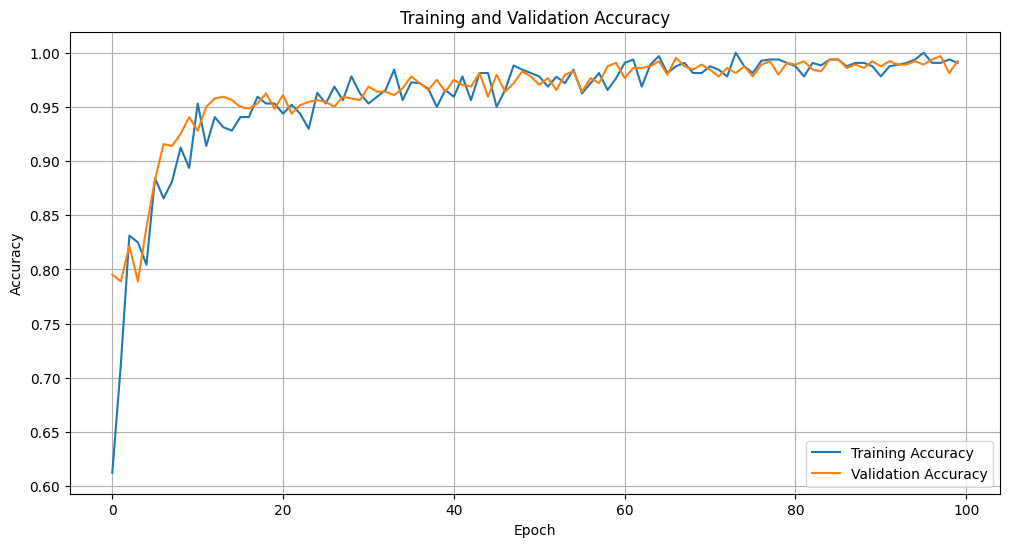

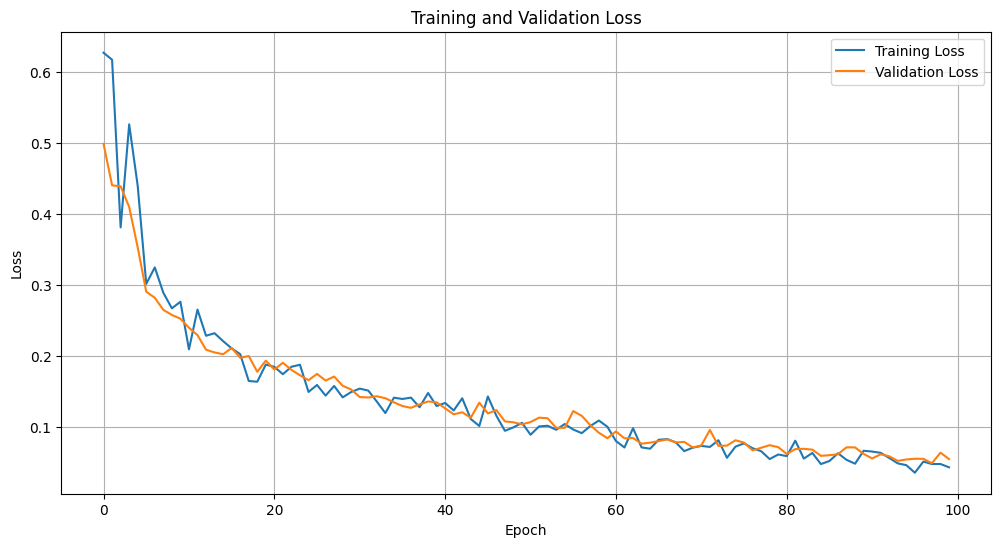

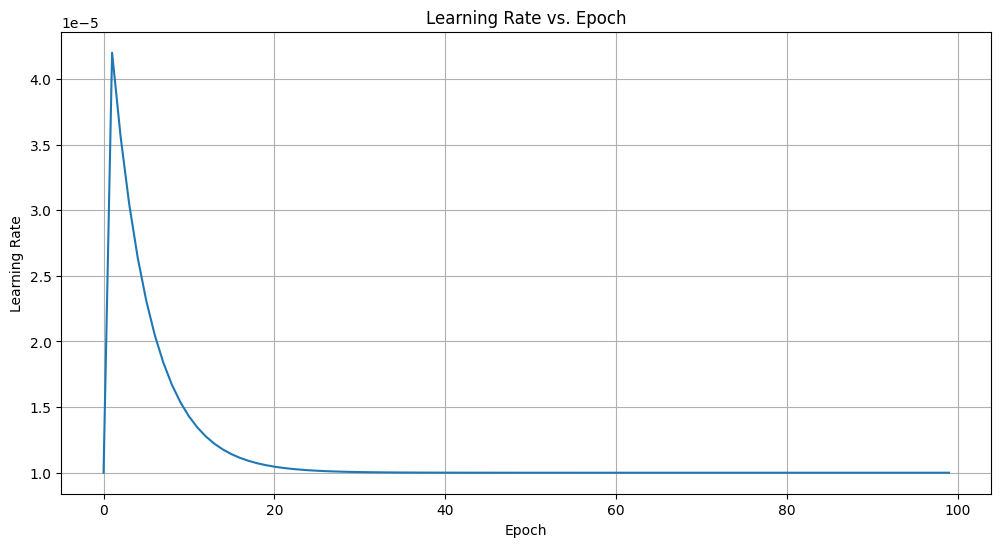

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    '/content/train111x',
    target_size=(300, 300),
    batch_size=64,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(
    '/content/validation111x',
    target_size=(300, 300),
    batch_size=64,
    class_mode='binary'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)



# Train the model
model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/best_model.keras")

# Summary of the loaded model
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2841728)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │       2,841,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,527,877 (32.53 MB)

 Trainable params: 2,842,625 (10.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,685,252 (21.69 MB)

Found 798 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step

Confusion Matrix:
[[369   9]
 [  3 417]]

Test Accuracy: 0.98

Precision: 0.98
Recall: 0.99
F1-Score: 0.99
AUC: 1.00


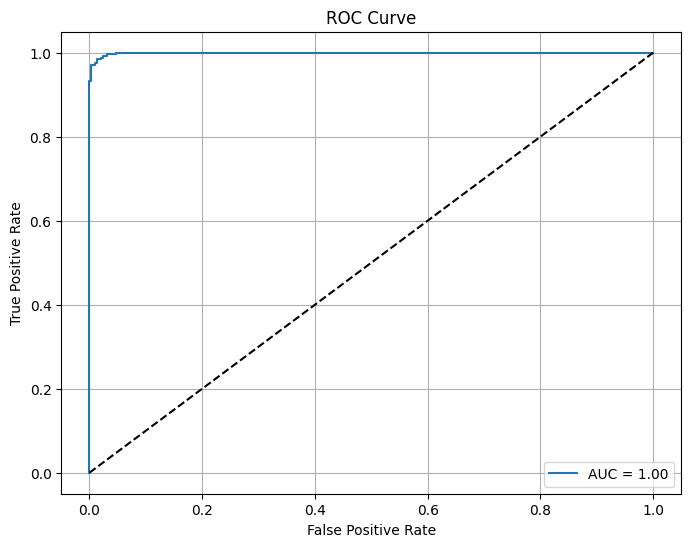

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the best saved model
best_model = load_model('/content/best_model.keras')

# Test data directory
test_data_dir = 'test111x'

# Image dimensions (adjust to your training dimensions)
img_height = 300
img_width = 300
batch_size = 40

# Preprocess test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generator for test images
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(300, 300),
    batch_size=40,
    class_mode='binary',  # Binary classification
    shuffle=False,  # Important for correct alignment
)

# Make predictions on test data
predictions = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)

# Convert probabilities to binary predictions
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ground truth labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)


# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Test Accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

# Precision, Recall, and F1-Score
precision = precision_score(true_classes, predicted_classes, average='binary')
recall = recall_score(true_classes, predicted_classes, average='binary')
f1 = f1_score(true_classes, predicted_classes, average='binary')
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# AUC-ROC Curve
auc_score = roc_auc_score(true_classes, predictions)
print(f"AUC: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Paired t-Test Results (Our Model vs Others):
Our Model vs Lung-EffNet B1 -> T-statistic: -1.2645, P-value: 0.2747
❌ No significant difference between Our Model and Lung-EffNet B1 (fail to reject null hypothesis)

Our Model vs EfficientNet B3 -> T-statistic: 0.5345, P-value: 0.6213
❌ No significant difference between Our Model and EfficientNet B3 (fail to reject null hypothesis)

Our Model vs EfficientNet B7 -> T-statistic: -0.7971, P-value: 0.4700
❌ No significant difference between Our Model and EfficientNet B7 (fail to reject null hypothesis)

Our Model vs EfficientNet B2 -> T-statistic: 3.1379, P-value: 0.0349
✅ Significant difference between Our Model and EfficientNet B2 (reject null hypothesis)

Our Model vs EfficientNet B2 with MCN -> T-statistic: -0.5098, P-value: 0.6370
❌ No significant difference between Our Model and EfficientNet B2 with MCN (fail to reject null hypothesis)

Our Model vs EfficientNet B5 -> T-statistic: 0.6772, P-value: 0.5354
❌ No significant difference betwe

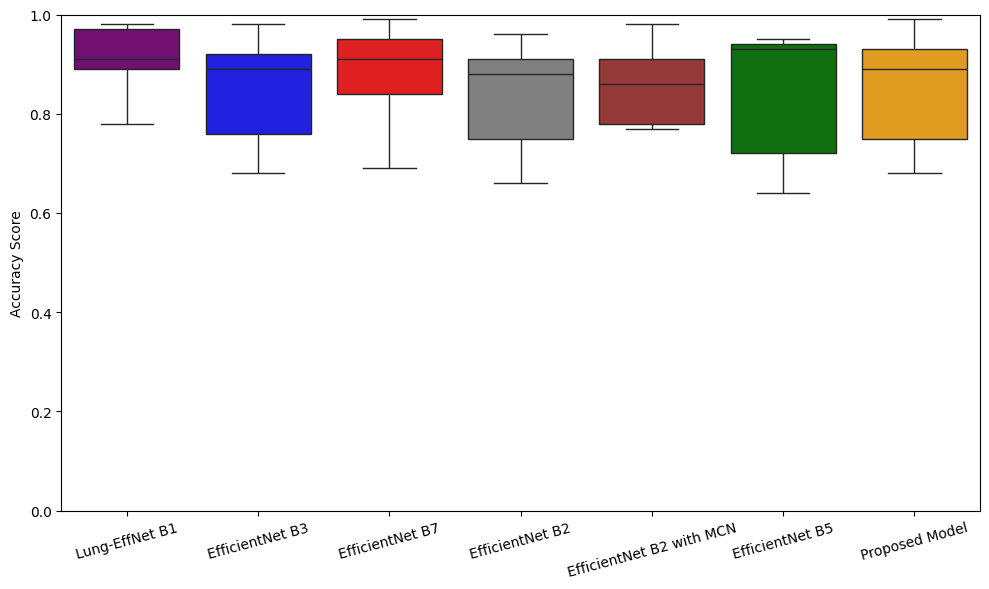

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy scores from different models
lung_effnet_b1 = [0.78, 0.97, 0.89, 0.91, 0.98]
efficientnet_b3 = [0.68, 0.76, 0.89, 0.92, 0.98]
efficientnet_b7 = [0.69, 0.91, 0.84, 0.95, 0.99]
efficientnet_b2 = [0.66, 0.75, 0.88, 0.91, 0.96]
efficientnet_b2_mcn = [0.78, 0.77, 0.86, 0.91, 0.98]
efficientnet_b5 = [0.64, 0.72, 0.93, 0.95, 0.94]
Proposed_model = [0.68, 0.75, 0.89, 0.93, 0.99]  # Baseline model

# Store models in a dictionary for pairwise t-tests
models = {
    "Lung-EffNet B1": lung_effnet_b1,
    "EfficientNet B3": efficientnet_b3,
    "EfficientNet B7": efficientnet_b7,
    "EfficientNet B2": efficientnet_b2,
    "EfficientNet B2 with MCN": efficientnet_b2_mcn,
    "EfficientNet B5": efficientnet_b5
}

# Perform paired t-tests comparing each model to "Our Model"
t_results = {}
for model_name, model_scores in models.items():
    t_stat, p_value = stats.ttest_rel(Proposed_model, model_scores)
    t_results[model_name] = (t_stat, p_value)

# Print results
print("Paired t-Test Results (Our Model vs Others):")
for model_name, (t_stat, p_value) in t_results.items():
    print(f"Our Model vs {model_name} -> T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"✅ Significant difference between Our Model and {model_name} (reject null hypothesis)\n")
    else:
        print(f"❌ No significant difference between Our Model and {model_name} (fail to reject null hypothesis)\n")

# Boxplot to compare accuracy distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=[lung_effnet_b1, efficientnet_b3, efficientnet_b7, efficientnet_b2,
                  efficientnet_b2_mcn, efficientnet_b5, Proposed_model],
            palette=["purple", "blue", "red", "gray", "brown", "green", "orange"])
plt.xticks(ticks=range(7),
           labels=["Lung-EffNet B1", "EfficientNet B3", "EfficientNet B7", "EfficientNet B2",
                   "EfficientNet B2 with MCN", "EfficientNet B5", "Proposed Model"],
           rotation=15)
plt.ylabel("Accuracy Score")

# Start y-axis at 0
plt.ylim(0, 1)

# (Optional) Fake xlim just to emphasize start from 0, though x-axis is categorical
plt.xlim(-0.5, 6.5)

plt.tight_layout()
plt.show()